# Task 3: Fundamental Diagram

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Define file path

In [70]:
# Group 2 US101SB Contour
# 10-19
volume_contour_10_19_path = "Group 2 US101SB/volume_contour_10-19.csv"
speed_contour_10_19_path = "Group 2 US101SB/speed_contour_10-19.csv"
density_contour_10_19_path = "Group 2 US101SB/density_contour_10-19.csv"
v_fitted_10_19_path = "Group 2 US101SB/v_fitted_10-19.csv"

# 10-26
volume_contour_10_26_path = "Group 2 US101SB/volume_contour_10-26.csv"
speed_contour_10_26_path = "Group 2 US101SB/speed_contour_10-26.csv"
density_contour_10_26_path = "Group 2 US101SB/density_contour_10-26.csv"
v_fitted_10_26_path = "Group 2 US101SB/v_fitted_10-26.csv"

# SR_91_Bottleneck_B_150-200
# 0831 - 0901
volume_contour_0831_0901_path = "SR_91_Bottleneck_B_150-200/volume_contour_0831-0901.csv"
speed_contour_0831_0901_path = "SR_91_Bottleneck_B_150-200/speed_contour_0831-0901.csv"
density_contour_0831_0901_path = "SR_91_Bottleneck_B_150-200/density_contour_0831-0901.csv"
v_fitted_0831_0901_path = "SR_91_Bottleneck_B_150-200/v_fitted_0831-0901.csv"

# 0907 - 0908
volume_contour_0907_0908_path = "SR_91_Bottleneck_B_150-200/volume_contour_0907-0908.csv"
speed_contour_0907_0908_path = "SR_91_Bottleneck_B_150-200/speed_contour_0907-0908.csv"
density_contour_0907_0908_path = "SR_91_Bottleneck_B_150-200/density_contour_0907-0908.csv"
v_fitted_0907_0908_path = "SR_91_Bottleneck_B_150-200/v_fitted_0907-0908.csv"

## 2. Load data

You can change the value of `DATE_FOR_ANALYSIS` to get result for different dataset.

In [71]:
# US101SB
# 10-19
volume_contour_10_19 = pd.read_csv(volume_contour_10_19_path)
speed_contour_10_19 = pd.read_csv(speed_contour_10_19_path)
density_contour_10_19 = pd.read_csv(density_contour_10_19_path)
# 10-26
volume_contour_10_26 = pd.read_csv(volume_contour_10_26_path)
speed_contour_10_26 = pd.read_csv(speed_contour_10_26_path)
density_contour_10_26 = pd.read_csv(density_contour_10_26_path)

# SR_91_Bottleneck_B_150-200
# 0831 - 0901
volume_contour_0831_0901 = pd.read_csv(volume_contour_0831_0901_path)
speed_contour_0831_0901 = pd.read_csv(speed_contour_0831_0901_path)
density_contour_0831_0901 = pd.read_csv(density_contour_0831_0901_path)
# 0907 - 0908
volume_contour_0907_0908 = pd.read_csv(volume_contour_0907_0908_path)
speed_contour_0907_0908 = pd.read_csv(speed_contour_0907_0908_path)
density_contour_0907_0908 = pd.read_csv(density_contour_0907_0908_path)

# Speed Contour for analysis
# DATE_FOR_ANALYSIS = "10-26"
DATE_FOR_ANALYSIS = "0907-0908"
if DATE_FOR_ANALYSIS == "10-19":
    speed_contour = speed_contour_10_19
    volume_contour = volume_contour_10_19
    density_contour = density_contour_10_19
    v_fitted_path = v_fitted_10_19_path
elif DATE_FOR_ANALYSIS == "10-26":
    volume_contour = volume_contour_10_26
    speed_contour = speed_contour_10_26
    density_contour = density_contour_10_26
    v_fitted_path = v_fitted_10_26_path
elif DATE_FOR_ANALYSIS == "0831-0901":
    volume_contour = volume_contour_0831_0901
    speed_contour = speed_contour_0831_0901
    density_contour = density_contour_0831_0901
    v_fitted_path = v_fitted_0831_0901_path
elif DATE_FOR_ANALYSIS == "0907-0908":
    volume_contour = volume_contour_0907_0908
    speed_contour = speed_contour_0907_0908
    density_contour = density_contour_0907_0908
    v_fitted_path = v_fitted_0907_0908_path


## 3. Explore the speed contour

In [72]:
# Set date as DateTimeIndex
speed_contour['date'] = pd.to_datetime(speed_contour['date'])
speed_contour.set_index('date', inplace=True)
# Replace any value greater than 80 with 80
speed_contour = speed_contour.applymap(lambda x: 80 if x > 80 else x)
speed_contour.fillna(-1, inplace=True)

/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/603311892.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  speed_contour = speed_contour.applymap(lambda x: 80 if x > 80 else x)


In [73]:
SPEED_JAMMED = 50
# Find stations with speed less than speed threshold, which is jammed condition.
stations = [col for col in speed_contour.columns 
            if ((speed_contour[col] < SPEED_JAMMED) & (speed_contour[col] > 0)).any()]
speed_contour_jammed = speed_contour[stations]

/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/1695941851.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_labels = pd.date_range(start='2017-09-07 00:00:00', end='2017-09-08 23:59:00', freq='2H')


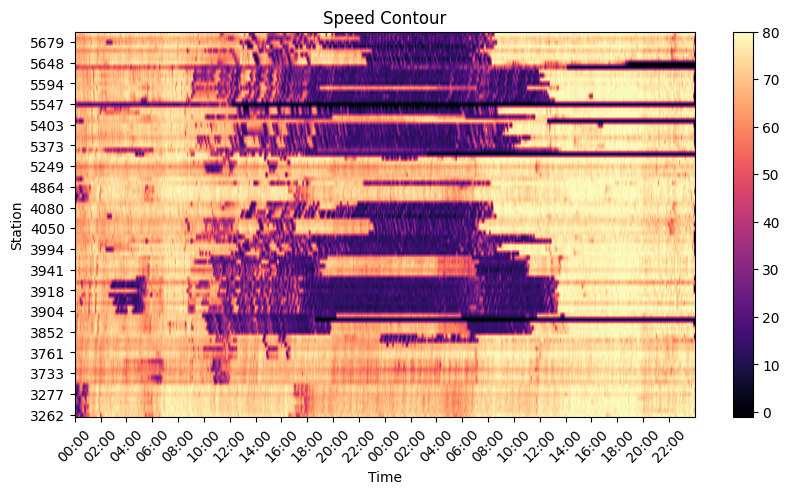

In [74]:
# Plot the speed contour as heatmap, date as x-axis, stations as y-axis, cell value as color (speed)
plt.figure(figsize=(10, 5))
plt.imshow(speed_contour_jammed.T, aspect='auto', cmap='magma', origin='lower', interpolation='bilinear')

# Generate hourly labels
dates = speed_contour_jammed.index
if DATE_FOR_ANALYSIS in ["10-19", "10-26"]:
    hourly_labels = pd.date_range(start='00:00:00', end='23:59:00', freq='H')
elif DATE_FOR_ANALYSIS in ["0831-0901", "0907-0908"]:
    hourly_labels = pd.date_range(start='2017-09-07 00:00:00', end='2017-09-08 23:59:00', freq='2H')

# Set x-axis labels to hourly
if DATE_FOR_ANALYSIS in ["10-19", "10-26"]:
    plt.xticks(ticks=np.arange(0, len(dates), 120), labels=hourly_labels.strftime('%H:%M'), rotation=45)
elif DATE_FOR_ANALYSIS in ["0831-0901", "0907-0908"]:
    plt.xticks(ticks=np.arange(0, len(dates) - 1, 120), labels=hourly_labels.strftime('%H:%M'), rotation=45)
plt.yticks(ticks=np.arange(0, len(stations),5), labels=stations[::5])
# Show color map
plt.title('Speed Contour')
plt.xlabel('Time')
plt.ylabel('Station')
plt.colorbar()
plt.show()

## 4. Plot fundamental diagram for one station

In [75]:
# Get a random station
random_number = np.random.randint(0, len(stations))
random_station = stations[random_number]

if DATE_FOR_ANALYSIS == "10-26":
    random_station = '410547'
elif DATE_FOR_ANALYSIS == "0907-0908":
    random_station = '4080'

In [76]:
# Get the speed, volume, and density of the random station
random_station_speed = speed_contour[random_station]
random_station_volume = volume_contour[random_station]
random_station_density = density_contour[random_station]

In [77]:
# Create a DataFrame for the random station
random_station_df = pd.DataFrame({'v': random_station_speed.values, 'q': random_station_volume.values, 'k': random_station_density.values})
random_station_df = random_station_df.dropna() # The NaN values are from the missing data at specific time
random_station_df = random_station_df[random_station_df['v'] > 0] # Remove the zero speed values
random_station_df.head()

,v,q,k
0,71.800000,20.0,2.673611
1,71.111111,18.0,1.701389
2,70.043478,23.0,2.673611
3,66.276596,47.0,6.562500
4,76.883721,43.0,5.104167


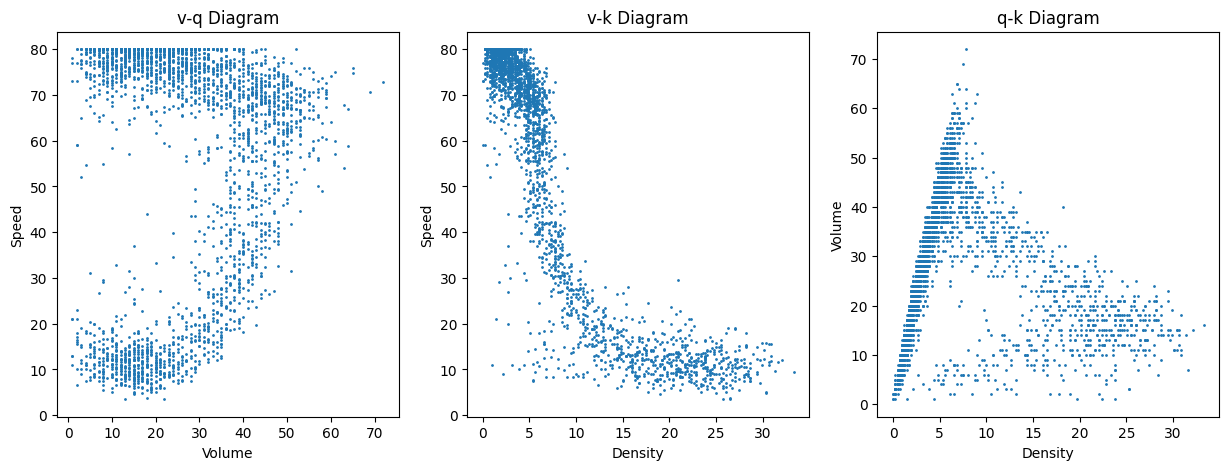

In [78]:
# Plot v-q, v-k, and q-k diagrams for one station
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(random_station_df['q'], random_station_df['v'], s=1)
plt.xlabel('Volume')
plt.ylabel('Speed')
plt.title('v-q Diagram')

plt.subplot(132)
plt.scatter(random_station_df['k'], random_station_df['v'], s=1)
plt.xlabel('Density')
plt.ylabel('Speed')
plt.title('v-k Diagram')

plt.subplot(133)
plt.scatter(random_station_df['k'], random_station_df['q'], s=1)
plt.xlabel('Density')
plt.ylabel('Volume')
plt.title('q-k Diagram')

plt.show()


# Task 4: Optimization

In [79]:
from scipy.optimize import curve_fit

## 1. Curve Fitting

In [80]:
# Get v, k from random station
random_station_df = random_station_df.sort_values(by='k')
v = random_station_df['v'].to_numpy()
k = random_station_df['k'].to_numpy()
print(v)

[73.         77.         59.         ... 11.57142857 12.
  9.5       ]


In [81]:
# Define the single-regime model to fit the data
def greenshields(k, v_f, k_jam):
    return v_f * (1 - k / k_jam)

def drake(k, v_f, k_m):
    return v_f * np.exp(-0.5 * (k / k_m)**2)

def five_pl(k, v_f, v_b, k_c, theta_1, theta_2):
    return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2

def s3(k, v_f, k_c, m):
    return v_f / (1 + (k/k_c)**m)**(2/m)

In [82]:
# Deinfe the Mean Squared Error (MSE) function
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [83]:
# Fit the greenshields model
popt, pcov = curve_fit(greenshields, k, v, bounds=([0, 0], [np.inf, np.inf]))
v_f, k_jam = popt
mse_greenshields = mse(v, greenshields(k, v_f, k_jam))
print(f'v_f: {v_f:.2f}, k_jam: {k_jam:.2f}') # 2 decimal places
print(f'MSE: {mse_greenshields:.2f}')

# Fit the drake model
popt, pcov = curve_fit(drake, k, v, bounds=([0, 0], [np.inf, np.inf]))
v_f, k_m = popt
mse_drake = mse(v, drake(k, v_f, k_m))
print(f'v_f: {v_f:.2f}, k_m: {k_m:.2f}')
print(f'MSE: {mse_drake:.2f}')

# Fit the five_pl model
popt, pcov = curve_fit(five_pl, k, v, bounds=([0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf]))
v_f, v_b, k_c, theta_1, theta_2 = popt
mse_five_pl = mse(v, five_pl(k, v_f, v_b, k_c, theta_1, theta_2))
print(f'v_f: {v_f:.2f}, v_b: {v_b:.2f}, k_c: {k_c:.2f}, theta_1: {theta_1:.2f}, theta_2: {theta_2:.2f}')
print(f'MSE: {mse_five_pl:.2f}')

# Fit the s3 model, with bournds for m, 1<=m<=8.53
popt, pcov = curve_fit(s3, k, v, bounds=([0, 0, 1], [np.inf, np.inf, 8.53]))
v_f, k_c, m = popt
mse_s3 = mse(v, s3(k, v_f, k_c, m))
print(f'v_f: {v_f:.2f}, k_c: {k_c:.2f}, m: {m:.2f}')
print(f'MSE: {mse_s3:.2f}')


v_f: 79.39, k_jam: 24.49
MSE: 159.43
v_f: 80.35, k_m: 7.24
MSE: 93.62
v_f: 70.50, v_b: 56.22, k_c: 0.10, theta_1: 0.00, theta_2: 13.12
MSE: 716.20
v_f: 77.44, k_c: 6.16, m: 4.12
MSE: 76.80


/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in exp
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2
/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in power
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2


## 2. Plot the curve

/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in exp
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2
/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in power
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2


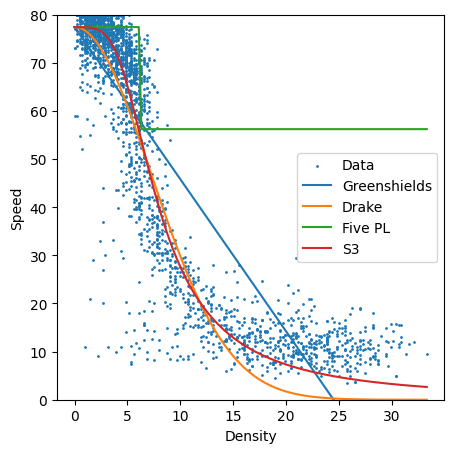

In [84]:
# Plot the fitted models in one single plot
plt.figure(figsize=(5, 5))
plt.scatter(k, v, s=1, label='Data')
plt.plot(k, greenshields(k, v_f, k_jam), label='Greenshields')
plt.plot(k, drake(k, v_f, k_m), label='Drake')
plt.plot(k, five_pl(k, v_f, v_b, k_c, theta_1, theta_2), label='Five PL')
plt.plot(k, s3(k, v_f, k_c, m), label='S3')
plt.xlabel('Density')
plt.ylabel('Speed')
plt.ylim(0, 80) # Set the y-axis limit from 0 to 80
plt.legend()
plt.show()



## Create data from t-test

In [85]:
v_fitted_greenshields = greenshields(k, v_f, k_jam)
v_fitted_drake = drake(k, v_f, k_m)
v_fitted_five_pl = five_pl(k, v_f, v_b, k_c, theta_1, theta_2)
v_fitted_s3 = s3(k, v_f, k_c, m)

v_fitted = pd.DataFrame({'date': DATE_FOR_ANALYSIS, 'greenshields': v_fitted_greenshields, 'drake': v_fitted_drake, 'five_pl': v_fitted_five_pl, 's3': v_fitted_s3})
v_fitted.to_csv(v_fitted_path, index=False)

/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in exp
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2
/var/folders/6g/xqgvnv4s1h95kfz0bd14h3_h0000gn/T/ipykernel_64574/2906647968.py:9: RuntimeWarning: overflow encountered in power
  return v_b + (v_f - v_b) / (1 + np.exp((k - k_c)/theta_1))**theta_2
